In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


In [2]:
# Load dataset
dataset = pd.read_csv('twitter.csv')

In [3]:
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [5]:
dataset.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [6]:
dataset["labels"] = dataset["class"].map({0: "Hate Speech",
                                          1: "Offensive language",
                                          2: "No Hate or Offensive language"})


In [7]:
dataset

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,labels
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate or Offensive language
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive language
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive language
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive language
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive language
...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,Offensive language
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",No Hate or Offensive language
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,Offensive language
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,Offensive language


In [8]:
data = dataset[["tweet", "labels"]]

In [9]:
data

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,No Hate or Offensive language
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive language
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive language
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive language
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive language
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,Offensive language
24779,"you've gone and broke the wrong heart baby, an...",No Hate or Offensive language
24780,young buck wanna eat!!.. dat nigguh like I ain...,Offensive language
24781,youu got wild bitches tellin you lies,Offensive language


In [10]:
# Preprocessing
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Data cleaning function
def clean_data(text):
    text = str(text).lower()  # Convert to lowercase
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'\[.*?\]', '', text)  # Remove text within square brackets
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers

    # Stopword removal
    text = [word for word in text.split() if word not in stop_words]
    text = " ".join(text)

    # Stemming the text
    text = [stemmer.stem(word) for word in text.split()]
    text = " ".join(text)

    return text

In [12]:
data["tweet"] = data["tweet"].apply(clean_data)

C:\Users\shada\AppData\Local\Temp\ipykernel_344\1832165696.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["tweet"] = data["tweet"].apply(clean_data)


In [13]:
data

,tweet,labels
0,rt mayasolov woman shouldnt complain clean hou...,No Hate or Offensive language
1,rt boy dat coldtyga dwn bad cuffin dat hoe place,Offensive language
2,rt urkindofbrand dawg rt ever fuck bitch start...,Offensive language
3,rt cganderson vivabas look like tranni,Offensive language
4,rt shenikarobert shit hear might true might fa...,Offensive language
...,...,...
24778,yous muthafin lie coreyemanuel right tl trash ...,Offensive language
24779,youv gone broke wrong heart babi drove redneck...,No Hate or Offensive language
24780,young buck wanna eat dat nigguh like aint fuck...,Offensive language
24781,youu got wild bitch tellin lie,Offensive language


In [14]:
# Feature engineering
X = np.array(data["tweet"])
y = np.array(data["labels"])

In [15]:
X

array(['rt mayasolov woman shouldnt complain clean hous amp man alway take trash',
       'rt boy dat coldtyga dwn bad cuffin dat hoe place',
       'rt urkindofbrand dawg rt ever fuck bitch start cri confus shit',
       ..., 'young buck wanna eat dat nigguh like aint fuckin dis',
       'youu got wild bitch tellin lie',
       'ruffl ntac eileen dahlia beauti color combin pink orang yellow amp white coll'],
      dtype=object)

In [16]:
y

array(['No Hate or Offensive language', 'Offensive language',
       'Offensive language', ..., 'Offensive language',
       'Offensive language', 'No Hate or Offensive language'],
      dtype=object)

In [17]:
cv = CountVectorizer(max_features=10000)  # Limit features to reduce overfitting
X = cv.fit_transform(X)

In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [19]:
# Build Decision Tree model with tuned hyperparameters
dt = DecisionTreeClassifier(criterion="gini", max_depth=25, min_samples_split=8, random_state=42)
dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=25, min_samples_split=8, random_state=42)

In [20]:
# Predictions
y_pred = dt.predict(X_test)

In [21]:
# Confusion Matrix and Accuracy
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 124   89  252]
 [   8 1311   60]
 [ 175  372 5788]]


<Axes: >

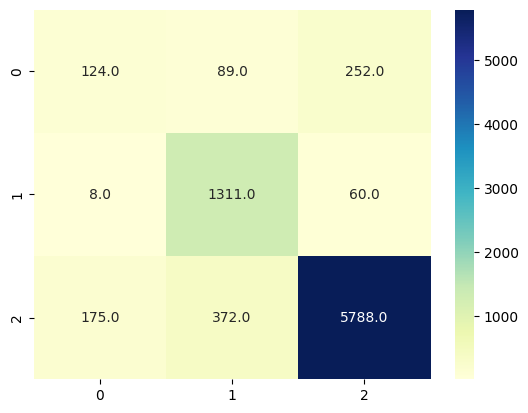

In [22]:
sns.heatmap(cm, annot=True, fmt=".1f", cmap="YlGnBu")

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8831152952683702


In [24]:
# Test with a sample input
sample = "This is a test tweet for hate speech detection."
sample = clean_data(sample)
if not sample.strip():
    print("Error: Input text is empty after preprocessing.")
else:
    data1 = cv.transform([sample]).toarray()
    prediction = dt.predict(data1)
    print("Predicted label:", prediction[0])

Predicted label: No Hate or Offensive language
